In [1]:

#%% import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


In [2]:
phosphate_level_N = pd.read_excel("raw-data/SW - Scottish Water Zonal Phosphate Levels.xls",
                                  sheet_name="North", header=None, skiprows=[0, 1, 2, 3, 4])
phosphate_level_S = pd.read_excel("raw-data/SW - Scottish Water Zonal Phosphate Levels.xls",
                                  sheet_name="South", header=None, skiprows=[0, 1, 2, 3, 4])
phosphate_level_E = pd.read_excel("raw-data/SW - Scottish Water Zonal Phosphate Levels.xls",
                                  sheet_name="East", header=None, skiprows=[0, 1, 2, 3, 4])
phosphate_level_W = pd.read_excel("raw-data/SW - Scottish Water Zonal Phosphate Levels.xls",
                                  sheet_name="West", header=None, skiprows=[0, 1, 2, 3, 4])
phosphate_level = phosphate_level_N
phosphate_level = phosphate_level.append(phosphate_level_S, ignore_index=True)
phosphate_level = phosphate_level.append(phosphate_level_E, ignore_index=True)
phosphate_level = phosphate_level.append(phosphate_level_W, ignore_index=True)

del phosphate_level_N
del phosphate_level_S
del phosphate_level_E
del phosphate_level_W

phosphate_level = phosphate_level.drop(columns=[8, 9])


In [3]:

def remove_empty_row(df: pd.DataFrame):
    # we delete all-empty rows
    not_null: np.ndarray = (np.logical_not(df.isnull()).sum(axis=1) > 0)
    not_null_df = df.loc[not_null, :]
    return not_null_df

def to_relational(df: pd.DataFrame):
    to_drop = []
    rig_name: str = None
    new_df = df.reset_index().drop(columns="index")
    rig_names = []

    rig_count = 0

    # put address into the first column
    for row in range(df.shape[0]):
        nonempty_num = np.sum(np.logical_not((new_df.iloc[row, :]).isnull()))

        if nonempty_num == 1:

            # should remove the following rows later
            to_drop += [row, row + 1, row + 2]

            # get the name of rig
            rig_name = new_df.iloc[row, 1]
            rig_names.append(rig_name)
            rig_count += 1

        else:
            new_df.iloc[row, 0] = rig_name

    print("the total number of rigs is : {}".format(rig_count))

    return (rig_names, new_df.drop(to_drop))



In [4]:
phosphate_level = remove_empty_row(phosphate_level)


In [5]:
header = phosphate_level.iloc[1:3, :]
new_header = ["rig_name"]

def combine(obj1, obj2):
    if str(obj1) == "nan":
        return str(obj2)
    else:
        return str(obj1) + " " + str(obj2)


for i in range(1, header.shape[1]):
    new_header += [combine(header.iloc[0, i], header.iloc[1, i])]

print("new headers: " + str(new_header))



new headers: ['rig_name', 'Sample Date', 'Sample Number', 'Sample Comments', 'Hydrogen ion pH value', 'Lead µgPb/l', 'Phosphorus µgP/l', 'Temperature °C']


In [6]:
rig_names, phosphate_level = to_relational(phosphate_level)
phosphate_level.columns = new_header
# 99 rigs


the total number of rigs is : 99


In [7]:
phosphate_level['Sample Date'] = pd.to_datetime(phosphate_level['Sample Date'])


In [8]:
comments = phosphate_level.loc[np.logical_not(phosphate_level["Sample Comments"].isnull()), :]


In [9]:
phosphate_level.drop(columns="Sample Comments", inplace=True)


In [10]:

pattern1 = re.compile(r".*-\s*(.*?)\s*[Zz]one.*$")

pattern2 = re.compile(r".*-\s*(.*?)\s*WTW.*$")

pattern3 = re.compile(r".*-\s*(.*?)\s*(\([\w\s]*\))?$")

trailing_pattern1 = re.compile(r"(.*?)/.*$")

trailing_pattern2 = re.compile(r"(.*?)\s+[A-Z]$")

trailing_pattern3 = re.compile(r"(.*?)\s+[Bb]ute$")

trailing_pattern4 = re.compile(r"(.*?)\s*\(.*\)$")

def remove_trailing_string(s: str):
    matcher1 = re.match(trailing_pattern1, s)
    matcher2 = re.match(trailing_pattern2, s)
    matcher3 = re.match(trailing_pattern3, s)
    matcher4 = re.match(trailing_pattern4, s)

    if matcher1 is not None:
        return matcher1.group(1)

    if matcher2 is not None:
        return matcher2.group(1)

    if matcher3 is not None:
        return matcher3.group(1)

    if matcher4 is not None:
        return matcher4.group(1)

    return s

def find_zone_name(s: str):
    matcher1 = re.match(pattern1, s)
    matcher2 = re.match(pattern2, s)
    matcher3 = re.match(pattern3, s)

    if matcher1 is not None:
        return remove_trailing_string(matcher1.group(1))

    if matcher2 is not None:
        return remove_trailing_string(matcher2.group(1))

    if matcher3 is not None:
        return remove_trailing_string(matcher3.group(1))

    return None


extracted_WOA = [find_zone_name(s) for s in rig_names]
extracted_WOA.sort()


In [11]:
postcode = pd.read_excel("raw-data/SW - Postcodes linked to SW Zonal Structure.xlsb", engine="pyxlsb")
valid_cols = [col for col in postcode.columns if col[0:7] != "Unnamed"]
postcode = postcode[valid_cols]
WOA_Name = postcode['WOA_Name'].unique()
WOA_Name = WOA_Name[np.logical_not(pd.isnull(WOA_Name))]
WSZ_Name = postcode['WSZ_Name'].unique()
WSZ_Name = WSZ_Name[np.logical_not(pd.isnull(WSZ_Name))]
del postcode


In [12]:
def find_match(str1: str) -> list:
    return_list = []
    for woa in WOA_Name:
        if str1.lower() in woa.lower():
            return_list += [woa]
    return return_list


WOA_mapper: dict = dict()

for woa in extracted_WOA:
    WOA_mapper[woa] = find_match(woa)



In [13]:
def find_match(str1: str) -> list:
    return_list = []
    for wsz in WSZ_Name:
        if str1.lower() in wsz.lower():
            return_list += [wsz]
    return return_list


WSZ_mapper: dict = dict()

for wsz in extracted_WOA:
    WSZ_mapper[wsz] = find_match(wsz)



In [14]:
phosphate_level = phosphate_level[~np.logical_or(pd.isnull(phosphate_level["Lead µgPb/l"]),
                                                 pd.isnull(phosphate_level["Phosphorus µgP/l"]))]



In [15]:

# remove values 20 times larger than moving median

phosphate_level.loc[:, 'Lead µgPb/l MVA'] = np.nan
phosphate_level.loc[:, 'Phosphorus µgP/l MVA'] = np.nan

for rig_name in rig_names:
    phosphate_level.loc[phosphate_level['rig_name'] == rig_name, 'Lead µgPb/l MVA'] = phosphate_level.loc[phosphate_level['rig_name'] == rig_name, 'Lead µgPb/l'].rolling(window=5).median()
    phosphate_level.loc[phosphate_level['rig_name'] == rig_name, 'Phosphorus µgP/l MVA'] = phosphate_level.loc[phosphate_level['rig_name'] == rig_name, 'Phosphorus µgP/l'].rolling(window=5).median()


In [16]:
median_ratio_Lead = phosphate_level.loc[:, 'Lead µgPb/l'] / phosphate_level.loc[:, 'Lead µgPb/l MVA']
median_ratio_Phosphorus = phosphate_level.loc[:, 'Phosphorus µgP/l'] / phosphate_level.loc[:, 'Phosphorus µgP/l MVA']

Lead_abnormal = median_ratio_Lead > 20
Phosphorus_abnormal = median_ratio_Phosphorus > 20

phosphate_level.loc[:, "Lead_abnormal"] = Lead_abnormal
phosphate_level.loc[:, "Phosphorus_abnormal"] = Phosphorus_abnormal


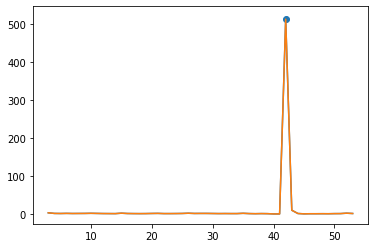

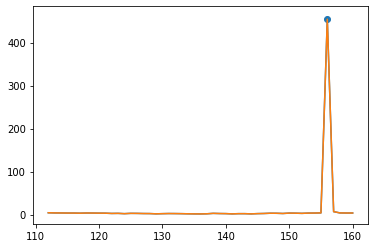

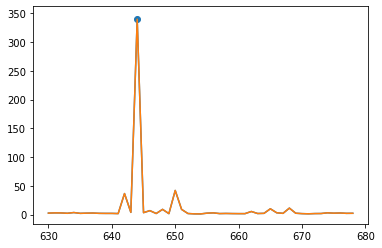

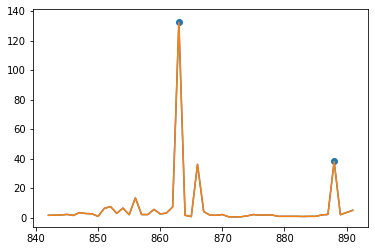

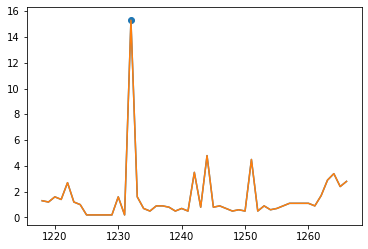

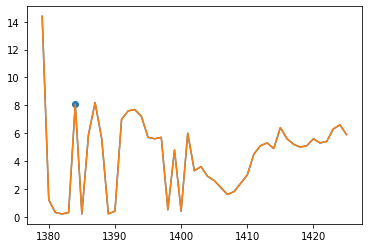

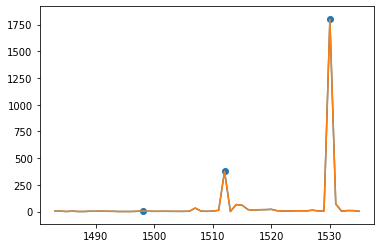

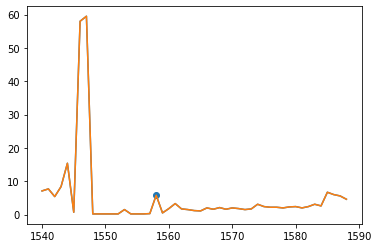

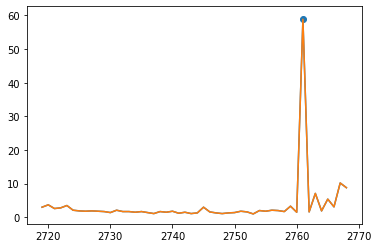

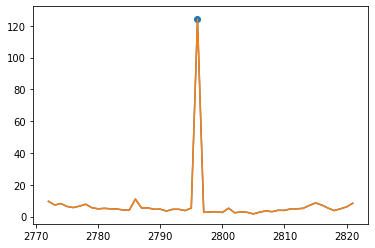

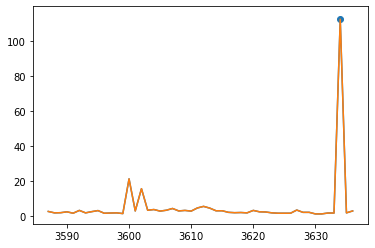

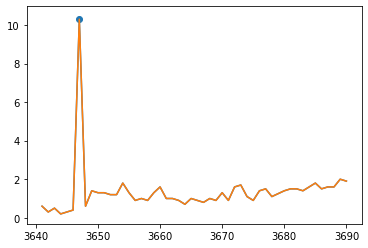

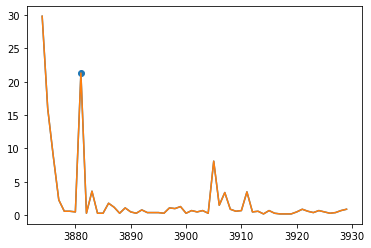

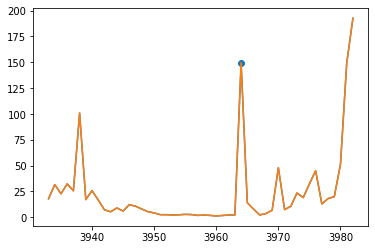

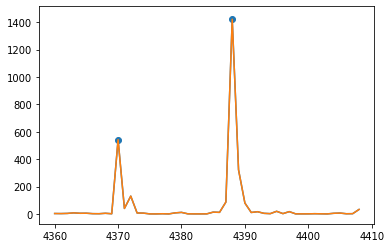

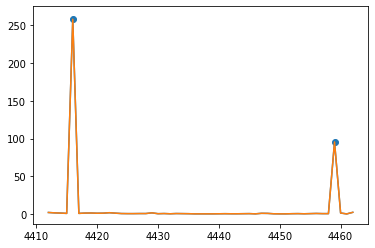

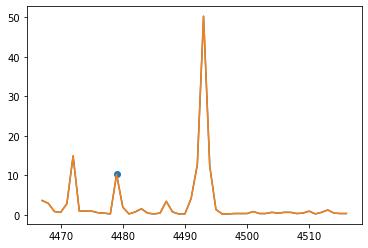

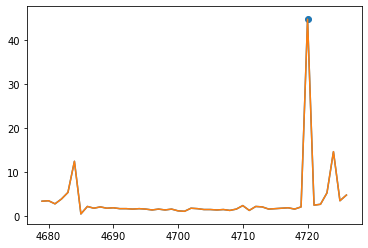

In [17]:
Lead_abnormal_ads = phosphate_level.loc[Lead_abnormal, "rig_name"].unique()
Phosphorus_abnormal_ads = phosphate_level.loc[Phosphorus_abnormal, "rig_name"].unique()

def get_line(rig_name: str, col_name: str):
    return phosphate_level.loc[phosphate_level['rig_name']==rig_name, col_name]

def get_x_points(rig_name: str, col_name: str):
    return phosphate_level.index[np.logical_and(phosphate_level['rig_name']==rig_name, phosphate_level[col_name.split(' ')[0] + "_abnormal"])]

def get_y_points(rig_name: str, col_name: str):
    return phosphate_level.loc[np.logical_and(phosphate_level['rig_name']==rig_name, phosphate_level[col_name.split(' ')[0] + "_abnormal"]), col_name]

for i in range(Phosphorus_abnormal_ads.shape[0]):
    fig, ax = plt.subplots(1, 1)
    ax.plot(get_line(Phosphorus_abnormal_ads[i], 'Phosphorus µgP/l'))
    ax.scatter(get_x_points(Phosphorus_abnormal_ads[i], 'Phosphorus µgP/l'), get_y_points(Phosphorus_abnormal_ads[i], 'Phosphorus µgP/l'))
    plt.plot(get_line(Phosphorus_abnormal_ads[i], 'Phosphorus µgP/l'))
    plt.show()
    plt.close()

for i in range(Lead_abnormal_ads.shape[0]):
    fig, ax = plt.subplots(1, 1)
    ax.plot(get_line(Lead_abnormal_ads[i], 'Lead µgPb/l'))
    ax.scatter(get_x_points(Lead_abnormal_ads[i], 'Lead µgPb/l'), get_y_points(Lead_abnormal_ads[i], 'Lead µgPb/l'))
    plt.plot(get_line(Lead_abnormal_ads[i], 'Lead µgPb/l'))
    plt.show()
    plt.close()



In [18]:
phosphate_level.loc[phosphate_level["Lead_abnormal"], 'Lead µgPb/l'] = np.nan
phosphate_level.loc[phosphate_level["Phosphorus_abnormal"], 'Phosphorus µgP/l'] = np.nan
